# Effective Sample Size (N_Effective)

## Effective Samples Introduction
From Wikipedia *In statistics and quantitative research methodology, a data sample is a set of data collected and/or selected from a statistical population by a defined procedure*. Properly sampling is one of the most challenging parts of experimental design for all statistics, one of the pitfalls being correlated data points in a sample.

For example if designing a drug to lower blood pressure, and if only able to 10 readings consider 3 designs.

1. 10 readings from 1 person
2. 10 readings from 10 people in one family
3. 10 readings from 10 random people

In each of these designs the number of data points remains the same, 10 readings, but an argument can be made that the **effective sample size** is not the same. In the first example, 10 readings from 1 person is a poor sample of if a drug works, there effectively was only one test if a drug had an effect. The second example is an improvement, but given knowledge of genetics family members will likely have similar reponses to a drug. The effective sample size is not one, but it could be argued that the sample size is greater than 10. In the last case 10 readings from 10 people would probably

The key notion is that effective samples are ones that present new information about the objective of the experiment.

## Effective Sample Size in Markov Chain Monte Carlo
In MCMC samples are draws from the Markov Chain. Before the chain reaches convergence draws could be correlated, meaning the nth sample may not be independent from the (n-1) draw.

To estimate the Gelman etal provide the following calculation $$\hat{n}_{eff} = \frac{mn}{1 + 2 \sum_{t=1}^T \hat{\rho}_t}$$

**TODO** Provide more information about effective sample size  



### Examples

In [55]:
import pymc3 as pm
import pystan
import arviz as az
import numpy as np

# Generate observed distribution with fixed parameters
SD = 2
MU = -5
obs = np.random.normal(loc=MU, scale=SD, size=10000)

### TODO Create an example of model with a high number of effective samples, and a low number of effective samples

Trying to create a model thats initialized with poor priors to show that correlated draws and model parametrization affects the effective number of samples, even when the same number of draws are taken from an MCMC distribution

Open to any other construction of example if there's better ideas. Trying to shoot for simple models that are easily understood.

In [56]:
# Set prior mean to -5000, very far from simulated mean
stan_model = """
data {
    int<lower=0> N;
    real obs[N];
}
parameters {
    real mu;
}
model {
    mu ~ normal(-5000, 1);
    obs ~ normal(mu, 2);
}
"""

In [57]:
fit = pystan.stan(model_code=stan_model, data={"obs":obs, "N":10000}, iter=500, chains=2, algorithm="NUTS")
az.effective_n(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_dead2b1f535232df23a68405b6def90f NOW.


In file included from /var/folders/gt/28pvdm614vd_2tn01llmx3s00000gp/T/tmpio82c7o8/stanfit4anon_model_dead2b1f535232df23a68405b6def90f_2597627455423963051.cpp:642:
In file included from /Users/canyon/.miniconda3/envs/arviz/lib/python3.6/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /Users/canyon/.miniconda3/envs/arviz/lib/python3.6/site-packages/numpy/core/include/numpy/ndarrayobject.h:18:
In file included from /Users/canyon/.miniconda3/envs/arviz/lib/python3.6/site-packages/numpy/core/include/numpy/ndarraytypes.h:1821:
/Users/canyon/.miniconda3/envs/arviz/lib/python3.6/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:15:2: warning: "Using deprecated NumPy API, disable it by "          "#defining NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it by " \
 ^
/var/folders/gt/28pvdm614vd_2tn01llmx3s00000gp/T/tmpio82c7o8/stanfit4anon_model_dead2b1f535232df23a68405b6def90f_259762745542396305

<xarray.Dataset>
Dimensions:  ()
Data variables:
    mu       float64 318.0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11ba49eb8>,
      dtype=object)

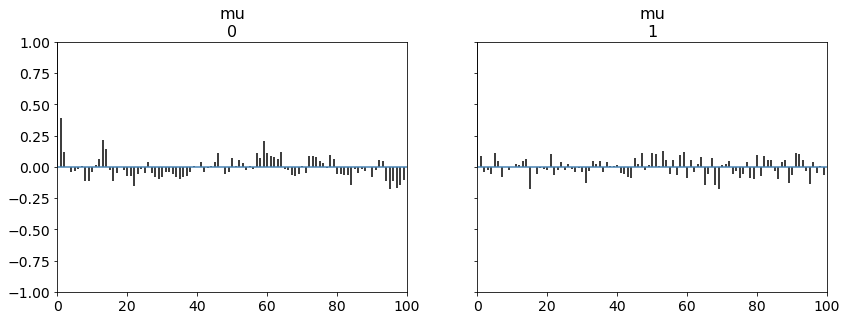

In [58]:
az.plot_autocorr(fit)

### TODO, create a model with less effective samples and explain why that happens

In [60]:
# Set prior mean to -5, exactly to prior mean
stan_model = """
data {
    int<lower=0> N;
    real obs[N];
}
parameters {
    real mu;
}
model {
    mu ~ normal(-5, 1);
    obs ~ normal(mu, 2);
}
"""

In [61]:
fit = pystan.stan(model_code=stan_model, data={"obs":obs, "N":10000}, iter=500, chains=2, algorithm="NUTS")
az.effective_n(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4d6898c286e45a9f74ce23a67f4b04eb NOW.


In file included from /var/folders/gt/28pvdm614vd_2tn01llmx3s00000gp/T/tmpnhqlnmjp/stanfit4anon_model_4d6898c286e45a9f74ce23a67f4b04eb_929144588070602651.cpp:642:
In file included from /Users/canyon/.miniconda3/envs/arviz/lib/python3.6/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /Users/canyon/.miniconda3/envs/arviz/lib/python3.6/site-packages/numpy/core/include/numpy/ndarrayobject.h:18:
In file included from /Users/canyon/.miniconda3/envs/arviz/lib/python3.6/site-packages/numpy/core/include/numpy/ndarraytypes.h:1821:
/Users/canyon/.miniconda3/envs/arviz/lib/python3.6/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:15:2: warning: "Using deprecated NumPy API, disable it by "          "#defining NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it by " \
 ^
/var/folders/gt/28pvdm614vd_2tn01llmx3s00000gp/T/tmpnhqlnmjp/stanfit4anon_model_4d6898c286e45a9f74ce23a67f4b04eb_929144588070602651.

<xarray.Dataset>
Dimensions:  ()
Data variables:
    mu       float64 217.0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11c851080>,
      dtype=object)

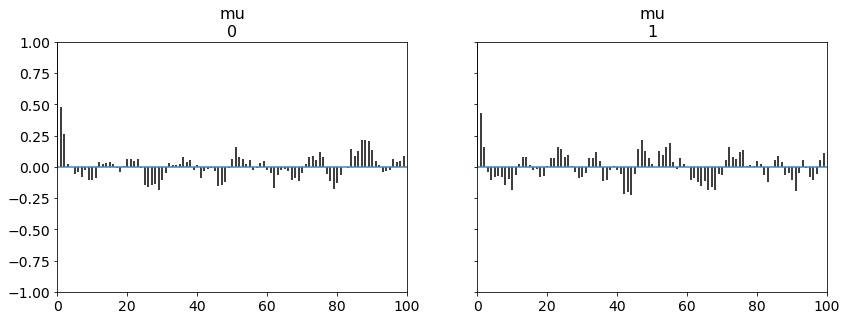

In [62]:
az.plot_autocorr(fit)

## PyMC3 (To show what Im trying to get at)

In [64]:
# Attempt to use pymc3 to estimate mean of the distribution
with pm.Model() as model:
    mu = pm.Normal("mu", mu=-5000, sd=1)
    y = pm.Normal("y", mu=mu, sd=SD, observed=obs)
    step = pm.Metropolis()
    trace = pm.sample(500, step, chains=2)
    
print(az.effective_n(trace))


# Attempt to use pymc3 to estimate mean of the distribution
with pm.Model() as model:
    mu = pm.Normal("mu", mu=-5, sd=1)
    y = pm.Normal("y", mu=mu, sd=SD, observed=obs)
    step = pm.Metropolis()
    trace = pm.sample(500, step, chains=2)
    
az.effective_n(trace)

Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [mu]
INFO:pymc3:Metropolis: [mu]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:00<00:00, 3948.47draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


<xarray.Dataset>
Dimensions:  ()
Data variables:
    mu       float64 4.0


Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [mu]
INFO:pymc3:Metropolis: [mu]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:00<00:00, 3636.81draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


<xarray.Dataset>
Dimensions:  ()
Data variables:
    mu       float64 91.0

#### The nice pystan output goes to the terminal (Possible to reverse outputs?)
<img src="PystanOutputInTerminal.png">

### Resources
[Effective Sample Size](https://www.youtube.com/watch?v=67zCIqdeXpo&t=227s) - Josh Starmer

### See also
Autocorrelation (TODO, Add link)